In [1]:
import struct
import zlib
from pynbt import NBTFile
import io
import os
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from scipy.sparse import coo_matrix
import tqdm


def translate_chunk_location(x, z, h_offset):
    region_x = x * 32
    region_z = z * 32
    
    chunk_x = int(region_x + (h_offset % 32));
    chunk_z = int(region_z + (h_offset / 32)); 
    
    return chunk_x, chunk_z


def get_chunk_offset_and_length(header, i):
    # Extract the four bytes for this chunk entry
    entry_bytes = header[i * 4: i * 4 + 4]

    # The first three bytes are the offset (big-endian)
    offset = int.from_bytes(entry_bytes[:3], 'big')

    # The fourth byte is the length
    length = entry_bytes[3]

    return offset, length
    

def read_region_file(filepath):
    # Get the filename from path.
    filename = filepath.split('/')[-1]

    # Filename format is r.x.z.mca
    filesplit = filename.split('.')

    # X and Z coords are parts 1 and 2 of the filename.
    x = int(filesplit[1])
    z = int(filesplit[2])
    
    chunks = {}
    chunk_mapping = {}
    # filename = f'data/region/r.{x}.{z}.mca'
    with open(f"{dir_path}/{filename}", 'rb') as file:
        # Region files begin with an 8192 byte header
        header = file.read(8192)

        # locations (1024 entries)
        for i in range(0, 1024):
            try:
                offset, length = get_chunk_offset_and_length(header, i)
                
                if offset == 0 and length == 0:
                    continue  # Chunk is not present
                    
                # Convert the offset to bytes (multiply by 4096)
                offset *= 4096
    
                # check past offset
                file.seek(0, 2)  # end to of file
                if file.tell() < offset: 
                    # offset is past file, no chunk exists
                    continue
    
                # goto offset and read 
                file.seek(offset)
                chunk_header = file.read(5)  # Read chunk length and compression type
                if len(chunk_header) < 5:
                    print(f"Incomplete chunk header for chunk {i}.")
                    continue
    
                chunk_length, compression_type = struct.unpack('>IB', chunk_header)
                chunk_length -= 1  # Subtract the compression type byte
    
                # Read and decompress the chunk data
                compressed_chunk_data = file.read(chunk_length)
                if len(compressed_chunk_data) < chunk_length:
                    print(f"Incomplete chunk data for chunk {i}.")
                    continue
    
                chunks[translate_chunk_location(x, z, i)] = {
                    'data': zlib.decompress(compressed_chunk_data),
                    'i': i,
                    'file': filename
                }
            except Exception as e:
                print(f"i={i}")
                print(f"chunk_length={chunk_length}")
                print(f"chunk_loc={translate_chunk_location(x, z, i)}")
                print(e)
                continue
            # chunks[(x, z, i)] = zlib.decompress(compressed_chunk_data)
    return chunks
        

In [2]:
def plot_chunks(sub_chunks):
    coords, file_indices = zip(*[(k, fnames.index(v['file'])+1) for k, v in sub_chunks.items()])

    cmap = matplotlib.colormaps['nipy_spectral'](np.linspace(.5, 1, len(fnames)))

    coords = np.array(coords)
    file_indices = np.array(file_indices)

    min_coords = np.min(coords, axis=0)
    max_coords = np.max(coords, axis=0)
    dim_sizes = max_coords - min_coords + 1

    # Create a 3D numpy array of zeros
    array_3d = np.zeros(dim_sizes, dtype=int)

    print("creating array_3d")
    # Set the values using advanced indexing
    array_3d[coords[:, 0] - min_coords[0], 
             coords[:, 1] - min_coords[1], 
             coords[:, 2] - min_coords[2]] = file_indices

    # Create a mapping from integer values to colors
    value_to_color = {i+1: cmap[i] for i, _ in enumerate(fnames)}

    # Plotting
    fig = plt.figure(figsize=(40, 8), constrained_layout=True)
    ax = fig.add_subplot(111, projection='3d')

    for val, _ in tqdm.tqdm(enumerate(fnames)):
        voxelarray = array_3d == val+1
        ax.voxels(voxelarray, facecolors=value_to_color[val+1], edgecolor='k')  # edgecolor is the color of the edges

    handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=value_to_color[val+1], markersize=10) 
               for val, label in enumerate(fnames)]
    ax.legend(handles=handles, title="Labels", loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
    
    plt.show()

In [3]:
def extract_sub_chunks(all_chunks):
    all_sub_chunks = {}
    for x_z, chunk in all_chunks.items():
        chunk_data = io.BytesIO(chunk['data'])
        nbt = NBTFile(chunk_data)
    
        for idx, section in enumerate(nbt['sections']):
            if plot_y:
                y_coord = section['Y'].value
            else:
                y_coord = 1
            # unpack x_z to create 3d coord tuple
            all_sub_chunks[(*(x_z), y_coord)] = {
                "data": section,
                "file": chunk['file']
            }
            if not plot_y:
                break

    return all_sub_chunks

r.-1.-1.mca
Loaded 559 chunks.
r.-1.0.mca
Loaded 432 chunks.
r.-2.-1.mca
Loaded 523 chunks.
r.-2.0.mca
Loaded 358 chunks.
creating array_3d


4it [00:02,  1.82it/s]


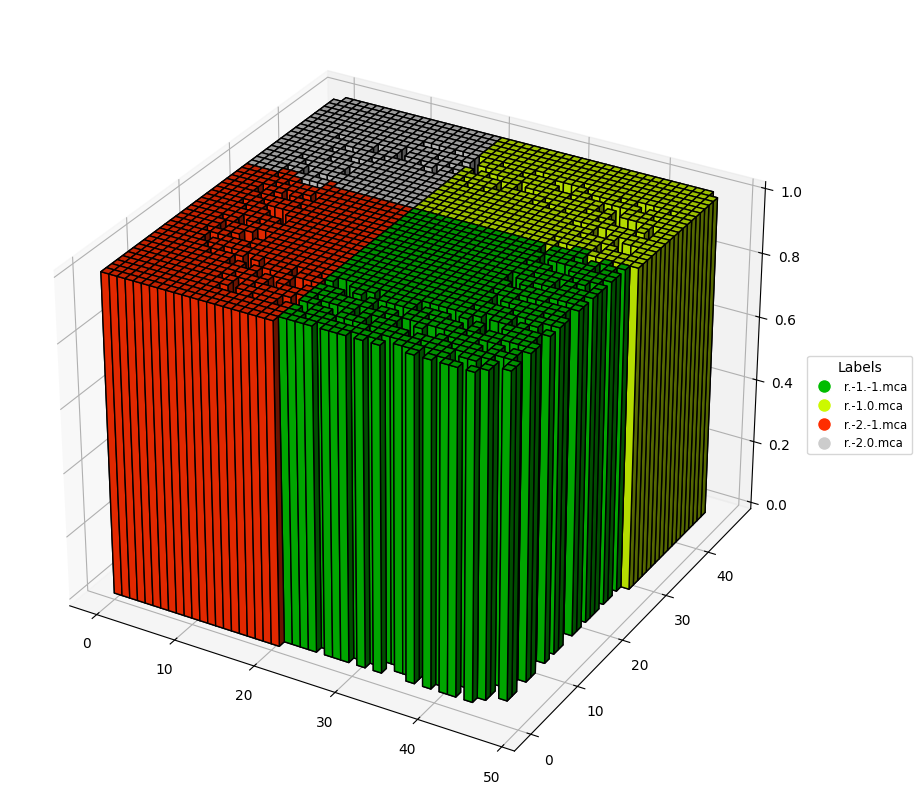

In [4]:
fnames = [fn for fn in os.listdir('data/region/') if '.mca' in fn]
dir_path = 'data/region/'
plot_y = False

all_chunks = {}
all_sub_chunks = {}
biome_full_palette = {}
block_full_palette = {}

for fname in fnames:
    print(f"{fname}")
    file_chunks = read_region_file(f'data/region/{fname}')
    
    print(f"Loaded {len(file_chunks)} chunks.")
    all_chunks.update(file_chunks)

all_sub_chunks = extract_sub_chunks(all_chunks)
plot_chunks(all_sub_chunks)